# Heralded CNOT
- This notebook demonstrates the operation of the Heralded CNOT gate from https://doi.org/10.1038/35051009.

In [3]:
import lightworks as lw
from lightworks import emulator, State

import numpy as np

## Initial version
- Build an initial version of the CNOT circuit. Note that the settings as provided below requires a special convention for the beam splitters, which we access with the convention = "H" setting.

In [6]:
# Set required element reflectivity
n1 = 2*np.arccos(1/(4-2*2**0.5)**0.5)
n2 = 2*np.arccos(2**0.5 - 1)

cnot_circuit = lw.Circuit(8)

# Loop over required elements, the format here is:
# (mode, [bs reflectivity, phase 1, phase 2])
data = [(0, [n1, np.pi, np.pi]), (4, [np.pi/2, 0, 0]), (6, [n1, 0, 0]),
        (1, [np.pi, 0, 0]), (3, [np.pi/2, 0, 0]), (5, [np.pi, 0, 0]),
        (2, [n2, 0, 0]), (4, [n2, np.pi, np.pi]), (1, [np.pi, 0, 0]), 
        (3, [np.pi/2, 0, 0]), (5, [np.pi, 0, 0]), (0, [n1, np.pi, np.pi]), 
        (4, [np.pi/2, 0, 0]), (6, [n1, 0, 0])]

# Loop over each element and add
for mode, d in data:
    theta, phi1, phi2 = d
    if phi1 > 0:
        cnot_circuit.add_ps(mode+1, phi1)
    cnot_circuit.add_bs(mode, reflectivity=np.cos(theta/2)**2, convention = "H")
    if phi2 > 0:
        cnot_circuit.add_ps(mode, phi2)

- View circuit with labelled modes. The c and t mode are the control and target qubit modes respectively, and the a and b modes are the ancillary modes required for implementation of the gate.

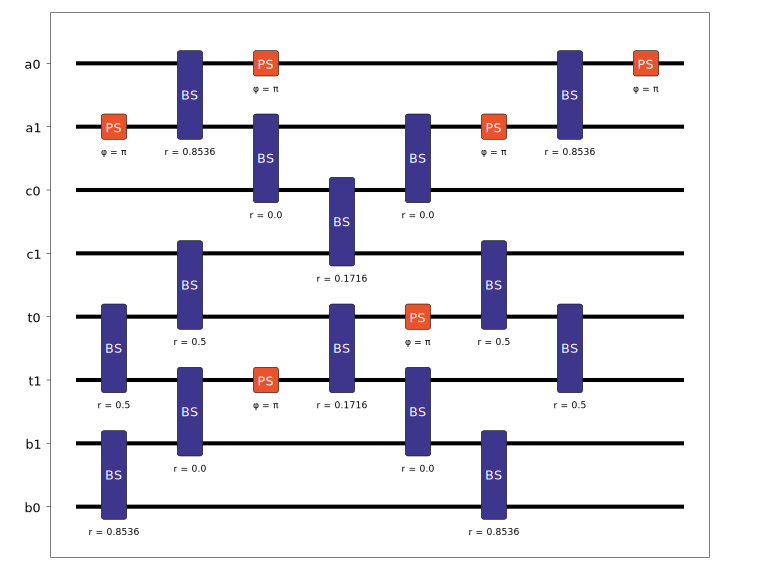

In [9]:
cnot_circuit.display(mode_labels = ["a0", "a1", "c0", "c1", "t0", "t1", "b1", "b0"])

## Sampling

In [10]:
# Set qubit input here
in_qubits = "10"

# This is then converted into modes
c, t = in_qubits
c, t = int(c), int(t)
in_state = State([0, 1, 1-c, c, 1-t, t, 1, 0])

# Run sampler with imperfect properties
source = emulator.Source(indistinguishability = 0.93, purity = 0.98)
detector = emulator.Detector(photon_counting = False)

sampler = emulator.Sampler(cnot_circuit, in_state, source = source,
                           detector = detector)

# Apply heralding rules and sample
N_rep = 10000
herald = lambda s: s[0] == 0 and s[1] == 1 and s[6] == 1 and s[7] == 0

results = sampler.sample_N_outputs(N_rep, herald = herald, min_detection = 4)

- It can be seen that in the case of a 10 input, the most likely output is 11 (|0,1,0,1> in mode language), as expected.

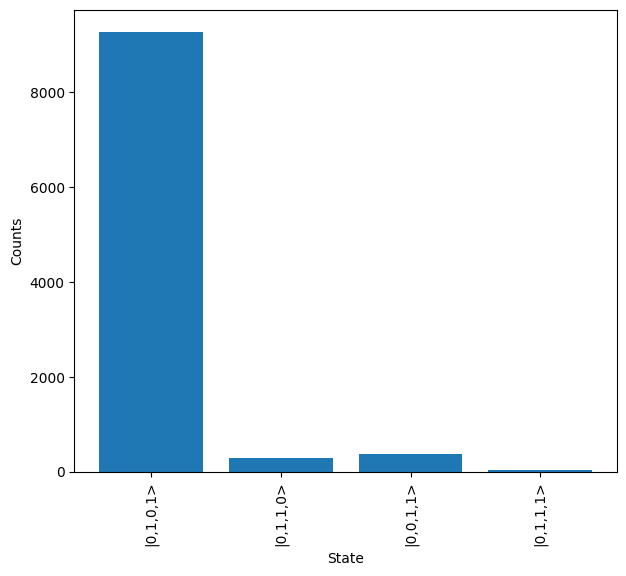

In [ ]:
# Remove heralded modes
state_labels = {s:State([s[2],s[3],s[4],s[5]]) for s in results.outputs}

results.plot(show = True, state_labels = state_labels)